In [107]:
import pandas as pd
import numpy as np
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [108]:
class DataDigest:

    def __init__(self):
        self.ages = None
        self.fares = None
        self.titles = None
        self.cabins = None
        self.families = None
        self.tickets = None


def get_title(name):
    if pd.isnull(name):
        return "Null"

    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1).lower()
    else:
        return "None"


def get_family(row):
    last_name = row["Name"].split(",")[0]
    if last_name:
        family_size = 1 + row["Parch"] + row["SibSp"]
        if family_size > 3:
            return "{0}_{1}".format(last_name.lower(), family_size)
        else:
            return "nofamily"
    else:
        return "unknown"


def get_index(item, index):
    if pd.isnull(item):
        return -1

    try:
        return index.get_loc(item)
    except KeyError:
        return -1


def munge_data(data, digest):
    data["AgeF"] = data.apply(lambda r: digest.ages[r["Sex"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)

    data["FareF"] = data.apply(lambda r: digest.fares[r["Pclass"]] if pd.isnull(r["Fare"]) else r["Fare"], axis=1)

    genders = {"male": 1, "female": 0}
    data["SexF"] = data["Sex"].apply(lambda s: genders.get(s))

    gender_dummies = pd.get_dummies(data["Sex"], prefix="SexD", dummy_na=False)
    data = pd.concat([data, gender_dummies], axis=1)

    embarkments = {"U": 0, "S": 1, "C": 2, "Q": 3}
    data["EmbarkedF"] = data["Embarked"].fillna("U").apply(lambda e: embarkments.get(e))

    embarkment_dummies = pd.get_dummies(data["Embarked"], prefix="EmbarkedD", dummy_na=False)
    data = pd.concat([data, embarkment_dummies], axis=1)

    data["RelativesF"] = data["Parch"] + data["SibSp"]
    data["SingleF"] = data["RelativesF"].apply(lambda r: 1 if r == 0 else 0)

    decks = {"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data["DeckF"] = data["Cabin"].fillna("U").apply(lambda c: decks.get(c[0], -1))

    deck_dummies = pd.get_dummies(data["Cabin"].fillna("U").apply(lambda c: c[0]), prefix="DeckD", dummy_na=False)
    data = pd.concat([data, deck_dummies], axis=1)

    title_dummies = pd.get_dummies(data["Name"].apply(lambda n: get_title(n)), prefix="TitleD", dummy_na=False)
    data = pd.concat([data, title_dummies], axis=1)

    data["CabinF"] = data["Cabin"].fillna("unknown").apply(lambda c: get_index(c, digest.cabins))
    data["TitleF"] = data["Name"].apply(lambda n: get_index(get_title(n), digest.titles))
    data["TicketF"] = data["Ticket"].apply(lambda t: get_index(t, digest.tickets))
    data["FamilyF"] = data.apply(lambda r: get_index(get_family(r), digest.families), axis=1)

    age_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90]
    data["AgeR"] = pd.cut(data["Age"].fillna(-1), bins=age_bins).astype(object)

    return data


def linear_scorer(estimator, x, y):
    scorer_predictions = estimator.predict(x)

    scorer_predictions[scorer_predictions > 0.5] = 1
    scorer_predictions[scorer_predictions <= 0.5] = 0

    return metrics.accuracy_score(y, scorer_predictions)

In [109]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
all_data = pd.concat([train_data, test_data])

In [110]:
print("===== survived by class and sex")
print(train_data.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True))

===== survived by class and sex
Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64


In [111]:
describe_fields = ["Age", "Fare", "Pclass", "SibSp", "Parch"]

print("===== train: males")
print(train_data[train_data["Sex"] == "male"][describe_fields].describe())

print("===== test: males")
print(test_data[test_data["Sex"] == "male"][describe_fields].describe())

print("===== train: females")
print(train_data[train_data["Sex"] == "female"][describe_fields].describe())

print("===== test: females")
print(test_data[test_data["Sex"] == "female"][describe_fields].describe())

===== train: males
              Age        Fare      Pclass       SibSp       Parch
count  453.000000  577.000000  577.000000  577.000000  577.000000
mean    30.726645   25.523893    2.389948    0.429809    0.235702
std     14.678201   43.138263    0.813580    1.061811    0.612294
min      0.420000    0.000000    1.000000    0.000000    0.000000
25%     21.000000    7.895800    2.000000    0.000000    0.000000
50%     29.000000   10.500000    3.000000    0.000000    0.000000
75%     39.000000   26.550000    3.000000    0.000000    0.000000
max     80.000000  512.329200    3.000000    8.000000    5.000000
===== test: males
              Age        Fare      Pclass       SibSp       Parch
count  205.000000  265.000000  266.000000  266.000000  266.000000
mean    30.272732   27.527877    2.334586    0.379699    0.274436
std     13.389528   41.079423    0.808497    0.843735    0.883745
min      0.330000    0.000000    1.000000    0.000000    0.000000
25%     22.000000    7.854200    2.0000

In [116]:
data_digest = DataDigest()

data_digest.ages = all_data.groupby("Sex")["Age"].median()
data_digest.fares = all_data.groupby("Pclass")["Fare"].median()

titles_trn = pd.Index(train_data["Name"].apply(get_title).unique())
titles_tst = pd.Index(test_data["Name"].apply(get_title).unique())
data_digest.titles = titles_tst

families_trn = pd.Index(train_data.apply(get_family, axis=1).unique())
families_tst = pd.Index(test_data.apply(get_family, axis=1).unique())
data_digest.families = families_tst

cabins_trn = pd.Index(train_data["Cabin"].fillna("unknown").unique())
cabins_tst = pd.Index(test_data["Cabin"].fillna("unknown").unique())
data_digest.cabins = cabins_tst

tickets_trn = pd.Index(train_data["Ticket"].fillna("unknown").unique())
tickets_tst = pd.Index(test_data["Ticket"].fillna("unknown").unique())
data_digest.tickets = tickets_tst

train_data_munged = munge_data(train_data, data_digest)
test_data_munged = munge_data(test_data, data_digest)
all_data_munged = pd.concat([train_data_munged, test_data_munged])

predictors = ["Pclass",
              "AgeF",
              "TitleF",
              "TitleD_mr", "TitleD_mrs", "TitleD_miss", "TitleD_master", "TitleD_ms",
              "TitleD_col", "TitleD_rev", "TitleD_dr",
              "CabinF",
              "DeckF",
              "DeckD_U", "DeckD_A", "DeckD_B", "DeckD_C", "DeckD_D", "DeckD_E", "DeckD_F", "DeckD_G",
              "FamilyF",
              "TicketF",
              "SexF",
              "SexD_male", "SexD_female",
              "EmbarkedF",
              "EmbarkedD_S", "EmbarkedD_C", "EmbarkedD_Q",
              "FareF",
              "SibSp", "Parch",
              "RelativesF",
              "SingleF"]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

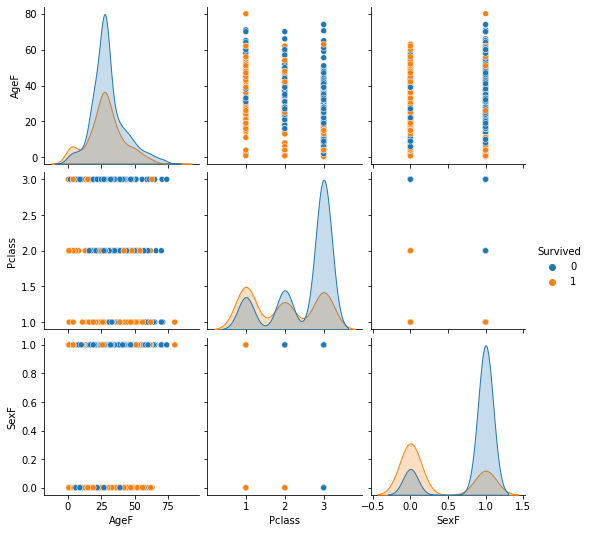

In [117]:
sns.pairplot(train_data_munged, vars=["AgeF", "Pclass", "SexF"], hue="Survived", dropna=True)

In [118]:
scaler = StandardScaler()
scaler.fit(all_data_munged[predictors])

train_data_scaled = scaler.transform(train_data_munged[predictors])
test_data_scaled = scaler.transform(test_data_munged[predictors])

In [119]:
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(alg_ngbh, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (Knn): {}/{}".format(scores.mean(), scores.std()))

Accuracy (Knn): 0.7890011223344556/0.015141119599587005
